In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [9]:
# initialize the intitial learning rate, number of epochs to train for and batch size

INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [10]:
DIRECTORY = 'dataset/'
CATEGORIES = ['with_mask', 'without_mask']

In [12]:
# grab the list of images in our dataset directory, then intiialize the list of data
print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        
        data.append(image)
        labels.append(category)

[INFO] loading images...


c:\Users\ACER\anaconda3\envs\py3819\lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [13]:
# Perfom One-hot encoding in the labesl
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype='float32')

(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

In [14]:
#construct the trainig image generator for data augmentaiton
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15, horizontal_flip=True,fill_mode='nearest')

In [15]:
#load the mobilenetv2 network, ensuring the head fc layer sets are lay off
baseModel = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

9406464/9406464 [==============================] - 2s 0us/step


In [18]:
#construct the head of the modelk that will be place on top of the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [19]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [22]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...


c:\Users\ACER\anaconda3\envs\py3819\lib\site-packages\keras\src\optimizers\legacy\adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20
89/89 [==============================] - 64s 685ms/step - loss: 0.4424 - accuracy: 0.8286 - val_loss: 0.1867 - val_accuracy: 0.9694
Epoch 2/20
89/89 [==============================] - 61s 686ms/step - loss: 0.1698 - accuracy: 0.9543 - val_loss: 0.0992 - val_accuracy: 0.9861
Epoch 3/20
89/89 [==============================] - 59s 657ms/step - loss: 0.1058 - accuracy: 0.9782 - val_loss: 0.0731 - val_accuracy: 0.9847
Epoch 4/20
89/89 [==============================] - 63s 703ms/step - loss: 0.0889 - accuracy: 0.9764 - val_loss: 0.0577 - val_accuracy: 0.9861
Epoch 5/20
89/89 [==============================] - 63s 703ms/step - loss: 0.0681 - accuracy: 0.9817 - val_loss: 0.0493 - val_accuracy: 0.9875
Epoch 6/20
89/89 [==============================] - 59s 665ms/step - loss: 0.0636 - accuracy: 0.9814 - val_loss: 0.0448 - val_accuracy: 0.9903
Epoch 7/20
89/89 [==============================] - 51s 576ms/step - loss: 0.0586 - accuracy: 0.9842 - val_loss: 0.0403 - val_accuracy: 0.9903

In [23]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

[INFO] evaluating network...
23/23 [==============================] - 9s 362ms/step
              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       359
without_mask       0.99      0.99      0.99       360

    accuracy                           0.99       719
   macro avg       0.99      0.99      0.99       719
weighted avg       0.99      0.99      0.99       719

[INFO] saving mask detector model...


c:\Users\ACER\anaconda3\envs\py3819\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


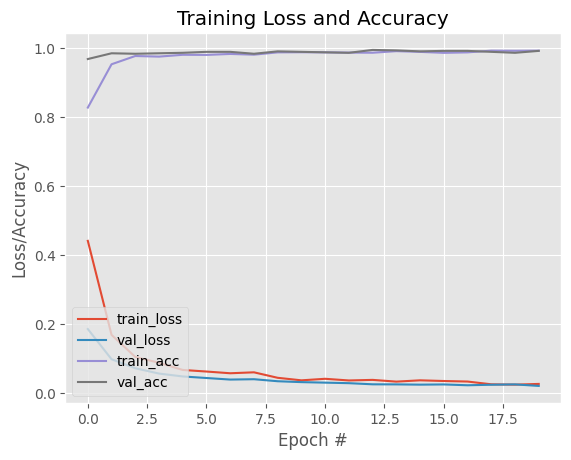

In [24]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")